# LSTM(Long Short-Term Memory) 구조

<img src = "./img/rnn_lstm.jpg">

- 단기 기억을 오래 하기 위해 고안되었음

<img src = "./img/lstm.png">

- 은닉 상태를 만드는 방법
    - output gate layer(출력 게이트)
         1. 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉상태를 만듦
             - 이 때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용
         2. tanh 활성화 함수를 통과한 값과 곱해져서 은닉 상태를 만듦
         
 - LSTM은 순환되는 상태가 2개
     - 은닉 상태
     - 셀 상태(cell state)
         - 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값
         
 - 셀 상태를 계산하는 과정
     - forget gate layer(삭제 게이트)
         - 정보를 제거하는 역할
         1. 입력과 은닉 상태를 또 다른 가중치에 곱한 다음 시그모이드 함수를 통과
         2. 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만듦
             - 이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여
         
     - input gate layer(입력 게이트)
         - 새로운 정보를 셀 상태에 추가
         1. 입력과 은닉 상태를 각기 다른 가중치에 곱함
         2. 하나는 시그모이드 함수, 하나는 tanh 함수를 통과
         3. 두 결과를 곱함
         4. 이전 셀 상태와 더함

## 데이터 준비

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 500)

In [3]:
# 훈련 세트와 검증 세트로 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,
                                                 random_state = 12)

In [4]:
# 패딩
train_seq = pad_sequences(x_train, maxlen = 100)
val_seq = pad_sequences(x_val, maxlen = 100)

In [5]:
# LSTM 모델 생성
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 32, input_shape = (100,))) # 32=하이퍼파라미터, 원하는대로 넣을 수 있음
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,321 (67.66 KB)

 Trainable params: 17,321 (67.66 KB)

 Non-trainable params: 0 (0.00 B)

- LSTM 셀 파라미터 개수
    - ((유닛 수  * 유닛수 ) + (입력값의 수 * 유닛 수) + 유닛 수) * 4
    - ((8 * 8) + (32 * 8) + 8) * 4 = 1312

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-lstm-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [8]:
history = model.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5205 - loss: 0.6923 - val_accuracy: 0.5538 - val_loss: 0.6903
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5983 - loss: 0.6886 - val_accuracy: 0.5946 - val_loss: 0.6828
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6301 - loss: 0.6780 - val_accuracy: 0.6584 - val_loss: 0.6538
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7004 - loss: 0.6284 - val_accuracy: 0.7162 - val_loss: 0.5739
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7389 - loss: 0.5581 - val_accuracy: 0.7390 - val_loss: 0.5491
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7575 - loss: 0.5322 - val_accuracy: 0.7614 - val_loss: 0.5266
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7691 - loss: 0.5126 - val_accuracy: 0.7664 - val_loss: 0.5087
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7807 - loss: 0.4917 - 

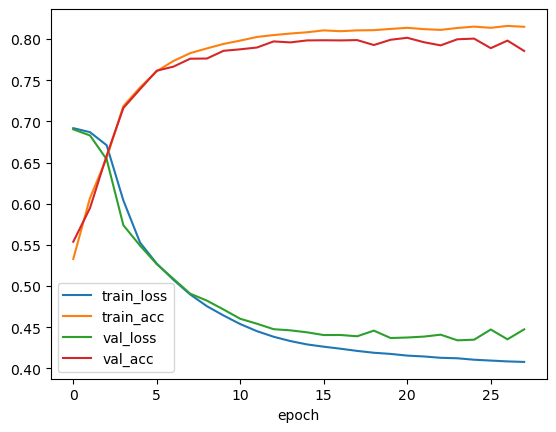

In [9]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 순환층에 드롭아웃 적용

- 순환층은 자체적으로 드롭아웃 기능을 제공
    - SimpleRNN 과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음
        - dropout : 셀의 입력에 드룹아웃을 적용
        - recurrent_dropout : 순환되는 은닉 상태에 드롭아웃을 적용
            - 버전에 따라 recurrent_dropout이 GPU를 사용하지 못하는 경우가 있음

In [10]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model2.add(keras.layers.LSTM(8, dropout = 0.3))
model2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [11]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-dropout-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [12]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5066 - loss: 0.6932 - val_accuracy: 0.5746 - val_loss: 0.6918
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5694 - loss: 0.6913 - val_accuracy: 0.6062 - val_loss: 0.6896
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6043 - loss: 0.6882 - val_accuracy: 0.6432 - val_loss: 0.6841
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6356 - loss: 0.6806 - val_accuracy: 0.6976 - val_loss: 0.6579
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6829 - loss: 0.6407 - val_accuracy: 0.7168 - val_loss: 0.5909
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7179 - loss: 0.5874 - val_accuracy: 0.7244 - val_loss: 0.5699
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7372 - loss: 0.5607 - val_accuracy: 0.7532 - val_loss: 0.5411
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7579 - loss: 0.5355 - 

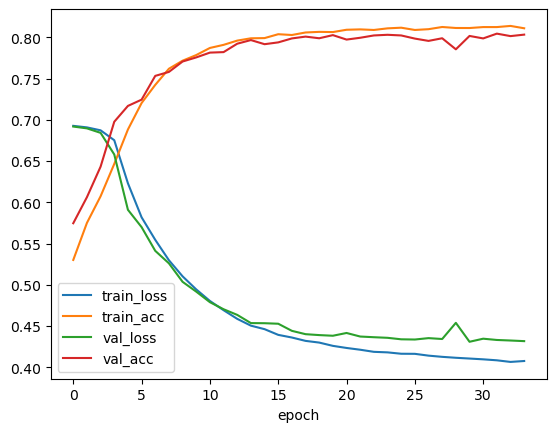

In [13]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 2개의 층을 연걸

- 순환층을 연결할 때의 주의점
    - 순환 층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달
        - 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요함
        - 앞 쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야함
            - return_sequences 매개변수를 True로 지정

In [13]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model3.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences = True))
model3.add(keras.layers.LSTM(8, dropout = 0.3)) # 마지막 출력층은 return_sequences 안 넣음~
model3.add(keras.layers.Dense(1, activation = "sigmoid"))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 8)              │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,865 (69.79 KB)

 Trainable params: 17,865 (69.79 KB)

 Non-trainable params: 0 (0.00 B)

- 첫 번째 LSTM
    - 모든 타임스텝(100개)의 은닉상태를 출력하기 때문에 출력의 크기가 (None, 100, 8)
- 두 번째 LSTM
    - 마지막 타임스텝의 은닉 상태만 출력하기 때문에 출력의 크기가 (None, 8)

In [16]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model3.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-2rnn-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [17]:
history = model3.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5063 - loss: 0.6930 - val_accuracy: 0.5678 - val_loss: 0.6925
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5574 - loss: 0.6922 - val_accuracy: 0.5802 - val_loss: 0.6912
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5778 - loss: 0.6902 - val_accuracy: 0.6214 - val_loss: 0.6864
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6153 - loss: 0.6829 - val_accuracy: 0.6552 - val_loss: 0.6600
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6647 - loss: 0.6433 - val_accuracy: 0.7084 - val_loss: 0.5775
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7034 - loss: 0.5782 - val_accuracy: 0.7362 - val_loss: 0.5405
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7477 - loss: 0.5325 - val_accuracy: 0.7586 - val_loss: 0.5134
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7604 - loss: 0.5071 -

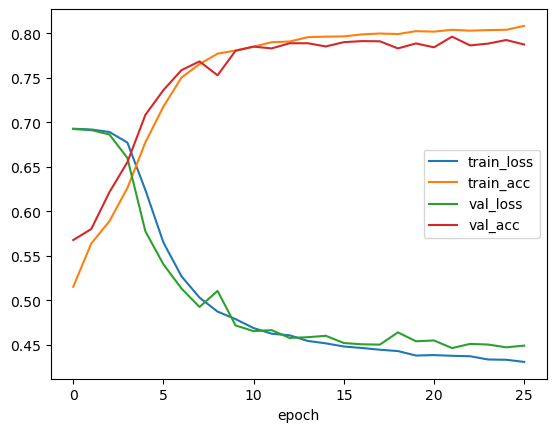

In [18]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show() 

# GRU(Grated Recurrent Unit) 구조

<img src = "./img/rnn_lstm_gru.png">

- LSTM을 간소화한 버전
- LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함
- LSTM보다 가중치가 적기 때문에 계산량이 적지만 성능은 LSTM과 유사함
    - 데이터 양이 적을 때는 GRU의 성능이 더 좋고 데이터 양이 많을 때는 LSTM의 성능이 더 좋아지는 경향이 있음
    - GRU와 LSTM 중 어떤 것이 더 낫다 라고 말할 수는 없음

<img src = "./img/gru.png">

- GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀 3개가 들어 있음
    - 2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용
    
- reset_gate
    - 셀의 출력이 은닉 상태에 바로 곱해져서 삭제 게이트 역할을 수행
    
- update_gate
    - 어떤 정보를 얼마만큼 유지하고 어떤 정보를 추가할지 결정하는 역할

In [5]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation = "sigmoid"))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 8)                   │           1,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,017 (66.47 KB)

 Trainable params: 17,017 (66.47 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
((32 * 8) + (8 * 8) + 8 + 8) * 3

1008

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-gru-model.keras",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [9]:
history = model4.fit(train_seq, y_train, epochs = 100, batch_size = 64,
                   validation_data = (val_seq, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5219 - loss: 0.6926 - val_accuracy: 0.5746 - val_loss: 0.6890
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5935 - loss: 0.6873 - val_accuracy: 0.6070 - val_loss: 0.6820
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6163 - loss: 0.6784 - val_accuracy: 0.6210 - val_loss: 0.6702
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6288 - loss: 0.6649 - val_accuracy: 0.6414 - val_loss: 0.6516
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6518 - loss: 0.6433 - val_accuracy: 0.6676 - val_loss: 0.6240
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6765 - loss: 0.6116 - val_accuracy: 0.6982 - val_loss: 0.5827
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7216 - loss: 0.5603 - val_accuracy: 0.7508 - val_loss: 0.5128
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7661 - loss: 0.4932 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8163 - loss: 0.4010 - val_accuracy: 0.7950 - val_loss: 0.4376


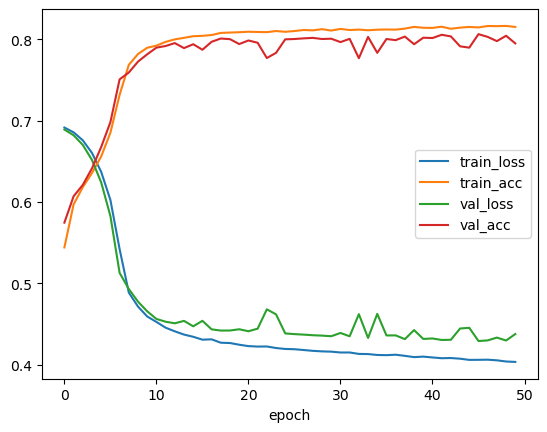

In [10]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show() 

# best  model 검증

In [12]:
test_seq = pad_sequences(x_test, maxlen = 100)
rnn_model = keras.models.load_model("./model/best-dropout-model.keras")
rnn_model.evaluate(test_seq, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8073 - loss: 0.4231


[0.4246894419193268, 0.8054400086402893]